In [ ]:
import numpy as np
from scipy.sparse import csr_matrix, find
from scipy.spatial import cKDTree
from tqdm import tqdm_notebook as tqdm

from datasets.graph import draw_sample
import torch

model_fname = '/home/lagray/hgcal_ldrd/checkpoints/model_checkpoint_EdgeNetWithCategories_264403_5b5c05404f_lagray.best.pth.tar'

test_fname = '/home/lagray/training_data/single_taus/test/processed/data_40.pt'

#weird stuff
#'/home/lagray/training_data/single_taus/test/processed/data_39.pt'
#'/home/lagray/training_data/single_taus/test/processed/data_41.pt'
#'/home/lagray/training_data/single_taus/test/processed/data_2.pt'
#'/home/lagray/training_data/single_taus/test/processed/data_26.pt'

from models.EdgeNetWithCategories import EdgeNetWithCategories

mdl = EdgeNetWithCategories(input_dim=5, hidden_dim=64, output_dim=4, n_iters=6).to('cuda:0')

mdl.load_state_dict(torch.load(model_fname)['model'])
mdl.eval()

test_fname = '/home/lagray/training_data/single_taus/processed/data_8069.pt'

data = torch.load(test_fname).to('cuda:0')

with torch.no_grad():
    pred_edges = mdl(data).detach()
    pred_edges_np = pred_edges.cpu().numpy()
    
print(np.unique(np.argmax(pred_edges_np,axis=-1), return_counts=True))
print(torch.unique(data.y.cpu(), return_counts=True))

X = data.x.cpu().numpy()
index = data.edge_index.cpu().numpy().T
Ro = index[:,0]
Ri = index[:,1]
y = data.y.cpu().numpy()

out = np.argmax(pred_edges_np,axis=-1)

In [ ]:
from unionfind import UnionFind
finder_had = UnionFind(X.shape[0])
finder_pho = UnionFind(X.shape[0])
finder_mip = UnionFind(X.shape[0])

for i in tqdm(range(index.shape[0])):
    if out[i] == 1:
        finder_had.union(index[i,0], index[i,1])
    if out[i] == 2:
        finder_pho.union(index[i,0], index[i,1])
    if out[i] == 3:
        finder_mip.union(index[i,0], index[i,1])

had_roots = np.array([finder_had.find(i) for i in range(X.shape[0])], dtype=np.uint32)
pho_roots = np.array([finder_pho.find(i) for i in range(X.shape[0])], dtype=np.uint32)
mip_roots = np.array([finder_mip.find(i) for i in range(X.shape[0])], dtype=np.uint32)

In [ ]:
had_clusters = np.unique(had_roots, return_inverse=True, return_counts=True)
pho_clusters = np.unique(pho_roots, return_inverse=True, return_counts=True)
mip_clusters = np.unique(mip_roots, return_inverse=True, return_counts=True)

hads = had_clusters[0][np.where(had_clusters[2] > 4)]
ems = pho_clusters[0][np.where(pho_clusters[2] > 4)]
mips = mip_clusters[0][np.where(mip_clusters[2] > 4)]

had_clusters_sel = {i: np.where(had_roots == had)[0] for i, had in enumerate(hads)}
em_clusters_sel = {i: np.where(pho_roots == em)[0] for i, em in enumerate(ems)}
mip_clusters_sel = {i: np.where(mip_roots == mip)[0] for i, mip in enumerate(mips)}

print(had_clusters_sel)
print(em_clusters_sel)
print(mip_clusters_sel)

print(had_clusters[2][np.where(had_clusters[2] > 4)])
print(pho_clusters[2][np.where(pho_clusters[2] > 4)])
print(mip_clusters[2][np.where(mip_clusters[2] > 4)])

In [ ]:
import torch_geometric
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T

from torch.utils.checkpoint import checkpoint
from torch_cluster import knn_graph

from torch_geometric.nn import EdgeConv
from torch_geometric.nn.pool.edge_pool import EdgePooling

from models.DynamicReductionNetwork import DynamicReductionNetwork

import warnings
warnings.simplefilter('ignore')

print(type(data))

def print_model_summary(model):
        """Override as needed"""
        print(
            'Model: \n%s\nParameters: %i' %
            (model, sum(p.numel() for p in model.parameters()))
        )

cls = []
cls.extend([torch_geometric.data.Data(x = torch.tensor(X[clus]), y=torch.tensor([20. + np.random.exponential()])) for clus in had_clusters_sel.values()])
cls.extend([torch_geometric.data.Data(x = torch.tensor(X[clus]), y=torch.tensor([.5 + np.random.exponential()])) for clus in em_clusters_sel.values()])
cls.extend([torch_geometric.data.Data(x = torch.tensor(X[clus]), y=torch.tensor([1.])) for clus in mip_clusters_sel.values()])

target = torch.tensor([30., 5., 2., 1.]).to('cpu')
datas = torch_geometric.data.DataLoader(cls, batch_size = 60)

#print(cl.x.shape, cl.x)

test = DynamicReductionNetwork(input_dim=5, hidden_dim=64, output_dim=1, k=8, aggr='max').to('cuda:0')
optimizer = torch.optim.Adam(test.parameters(), lr=0.001, weight_decay=5e-3)

print(print_model_summary(test))

test.train()

for e in tqdm(range(300)):
    test.train()
    optimizer.zero_grad()
    for i, datum in enumerate(datas):
        temp = datum.to('cuda:0')
        result = test(temp, temp.batch) 
        mse = F.mse_loss(result, temp.y, reduction='mean')
        mse.backward()
        optimizer.step()
        print(mse.item(), result, datum.y)

#batch = torch.zeros(cl.x.shape[0], dtype=torch.int64).to('cuda:0')
#val = test(cl, batch)
#test(cl, batch).backward()
#print(val)

In [ ]:
import numpy as np

np.random.exponential(size=3)

tensor([5])


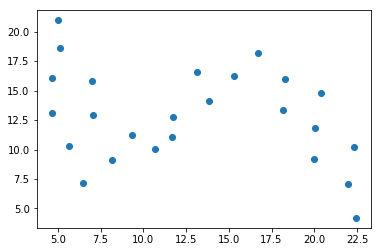

In [1]:
import os.path as osp

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import MNISTSuperpixels
import torch_geometric.transforms as T
from torch_geometric.data import DataLoader
from tqdm import tqdm_notebook as tqdm

from models.DynamicReductionNetwork import DynamicReductionNetwork

import warnings
warnings.simplefilter('ignore')

path = osp.join('./', '..', 'data', 'MNIST')
transform = T.Cartesian(cat=False)
train_dataset = MNISTSuperpixels(path, True, transform=transform)
test_dataset = MNISTSuperpixels(path, False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
d = train_dataset

%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import collections  as mc

i = 0
mask = (d[i].x > 0).squeeze()
plt.scatter(d[i].pos[mask,1], d[i].pos[mask,0])
print(d[i].y)

In [ ]:
print('features ->', d.num_features)
print('classes ->',d.num_classes)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.drn = DynamicReductionNetwork(input_dim=3, hidden_dim=128,
                                           n_iters = 4,
                                           k = 20,
                                           output_dim=d.num_classes, aggr='add',
                                           norm=torch.tensor([1., 1./27., 1./27.]))
        
    def forward(self, data):
        logits = self.drn(data)
        return F.log_softmax(logits, dim=1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(epoch):
    model.train()

    if epoch == 16:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.001

    if epoch == 26:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.0001

    for data in tqdm(train_loader):
        data = data.to(device)        
        mask = (data.x > 0.).squeeze()
        data.x = torch.cat([data.x, data.pos], dim=-1)
        data.x = data.x[mask,:]
        #print(data.x)
        data.pos = data.pos[mask,:]
        data.batch = data.batch[mask.squeeze()]
        optimizer.zero_grad()
        result = model(data)
        F.nll_loss(result, data.y).backward()
        #print(torch.unique(torch.argmax(result, dim=-1)))
        #print(torch.unique(data.y))
        optimizer.step()


def test():
    model.eval()
    correct = 0

    for data in test_loader:
        data = data.to(device)
        mask = (data.x > 0.).squeeze()
        data.x = torch.cat([data.x, data.pos], dim=-1)
        data.x = data.x[mask,:]
        #print(data.x)
        data.pos = data.pos[mask,:]
        data.batch = data.batch[mask.squeeze()]
        pred = model(data).max(1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(test_dataset)


for epoch in range(1, 31):
    train(epoch)
    test_acc = test()
    print('Epoch: {:02d}, Test: {:.4f}'.format(epoch, test_acc))

features -> 1
classes -> 10



Epoch: 01, Test: 0.8334



Epoch: 02, Test: 0.9415



Epoch: 03, Test: 0.9388



Epoch: 04, Test: 0.9698



Epoch: 05, Test: 0.9624



Epoch: 06, Test: 0.9752



Epoch: 07, Test: 0.9736



Epoch: 08, Test: 0.9614



Epoch: 09, Test: 0.9740



Epoch: 10, Test: 0.9759



Epoch: 11, Test: 0.9722



Epoch: 12, Test: 0.9776
